## Aim of the algorithm

This algorithm aims for the computation of the evolution/emergence of altruism in a population composed of breeders, offspring and waiters. To do so, we set some parameters and compute the evolution of the eigenvalues in function of the altruism parameter, h_x/eta_x and on the value of some parameters depending on the experiments.

### Libraries

In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings
using Profile
using Random
using CSV
using DataFrames


Parameters

In [2]:
#survivals:
s_u = 0.4
s_x = 0.5
s_y = 0.5
s_jx = 0.4
s_jy = 0.4


#fecundity
b_x = 4
b_y = 5
phi = 0.1
M = 1

#altruism
h_x = 0
h_y = 0

h_x_bar = h_x
h_y_bar = h_y

T_x(h_x_bar) = 1-exp(-b_x*h_x_bar)
T_y(h_y_bar) = exp(-b_y*h_y_bar)

theta_x(x,y) = (1-phi)*x/(x+y)
theta_y(x,y) = (1-phi)*y/(x+y) 
psi_x(x,y) = theta_x(x,y)+1+phi
psi_y(x,y) = theta_y(x,y)+1+phi


#competition
a = 0.1
p_u = 0.6
p_u_tilde(x,y) = p_u/(1+a*(x+y))
p_j = 0.58
p_j_tilde(x,y) = p_j/(1+a*(x+y))

parameters = Dict("b_x"=>b_x,"b_y"=>b_y,"s_u"=>s_u,"s_jx"=>s_jx,"s_jy"=>s_jy,"s_x"=>s_x,"s_y"=>s_y,"phi"=>phi,"M"=>M,"a"=>a,"p_u"=>p_u,"p_j"=>p_j,"h_x" =>h_x,"h_x_bar" =>h_x_bar,"h_y" =>h_y, "h_y_bar" =>h_y_bar)

#time
t_0 = 0
t_max = 100

#Relatedness
R_jp = 1/2*(1+phi)
R_siblings = (phi^2+(1-phi)^2*(1/4+1/(4*M)))+1


1.415

Matrices definitions

In [3]:
# Wild type matrix
function A(x,y,parameters) 
    
    b_x = parameters["b_x"]
    b_y = parameters["b_y"]
    s_u = parameters["s_u"]
    s_jx = parameters["s_jx"]
    s_jy = parameters["s_jy"]
    s_x = parameters["s_x"]
    s_y = parameters["s_y"]
    p_u = parameters["p_u"]
    p_j = parameters["p_j"]
    a = parameters["a"]
    M = parameters["M"]
    phi = parameters["phi"]
    h_x = parameters["h_x"]
    h_y = parameters["h_y"]
    h_x_bar = parameters["h_x_bar"]
    h_y_bar = parameters["h_y_bar"]
    p_u_tilde(x,y) = p_u/(1+a*(x+y))
    p_j_tilde(x,y) = p_j/(1+a*(x+y))
    h_x = parameters["h_x"]
    h_y = parameters["h_y"]
    h_x_bar = parameters["h_x_bar"]
    h_y_bar = parameters["h_y_bar"]
    
    return [s_u*(1-p_u_tilde(x,y)) 0 0 (1-h_x)*s_u*(1-p_u_tilde(x,y))+h_x*(T_x(h_x_bar)*s_jy+(1-T_x(h_x_bar))*s_jx)*(1-p_j_tilde(x,y)) (1-h_y)*s_u*(1-p_u_tilde(x,y))+h_y*(T_y(h_y_bar)*s_jx+(1-T_y(h_y_bar))*s_jy)*(1-p_j_tilde(x,y))
    ; s_u*p_u_tilde(x,y) (1-T_x(h_x_bar))*s_x T_y(h_y_bar)*s_x (1-h_x)*s_u*p_u_tilde(x,y)+h_x*(T_x(h_x_bar)*s_jy+(1-T_x(h_x_bar))*s_jx)*p_j_tilde(x,y) (1-h_y)*s_u*p_u_tilde(x,y)+h_y*(T_y(h_y_bar)*s_jx+(1-T_y(h_y_bar)*s_jy))*p_j_tilde(x,y)
    ; 0 T_x(h_x_bar)*s_y (1-T_y(h_y_bar))*s_y 0 0
    ; s_u*p_u_tilde(x,y)*b_x (1-T_x(h_x_bar))*s_x*b_x T_y(h_y_bar)*s_x*b_x (1-h_x)*s_u*p_u_tilde(x,y)*b_x+h_x*(T_x(h_x_bar)*s_jy+(1-T_x(h_x_bar))*s_jx)*p_j_tilde(x,y)*b_x (1-h_y)*s_u*p_u_tilde(x,y)*b_x+h_y*(T_y(h_y_bar)*s_jx+(1-T_y(h_y_bar))*s_jy)*p_j_tilde(x,y)*b_x
    ; 0 T_x(h_x_bar)*s_y*b_y (1-T_y(h_y_bar))*s_y*b_y 0 0
    ];
end

# Mutant matrix
function Mutant(x,y,parameters) 
    
    b_x = parameters["b_x"]
    b_y = parameters["b_y"]
    s_u = parameters["s_u"]
    s_jx = parameters["s_jx"]
    s_jy = parameters["s_jy"]
    s_x = parameters["s_x"]
    s_y = parameters["s_y"]
    p_u = parameters["p_u"]
    p_j = parameters["p_j"]
    a = parameters["a"]
    p_u_tilde(x,y) = p_u/(1+a*(x+y))
    p_j_tilde(x,y) = p_j/(1+a*(x+y))
    M = parameters["M"]
    phi = parameters["phi"]
    h_x = parameters["h_x"]
    h_y = parameters["h_y"]
    h_x_bar = parameters["h_x_bar"]
    h_y_bar = parameters["h_y_bar"]
    return [s_u*(1-p_u_tilde(x,y)) 0 0 (1-h_x)*s_u*(1-p_u_tilde(x,y))+h_x*(T_x(h_x_bar)*s_jy+(1-T_x(h_x_bar))*s_jx)*(1-p_j_tilde(x,y)) (1-h_y)*s_u*(1-p_u_tilde(x,y))+h_y*(T_y(h_y_bar)*s_jx+(1-T_y(h_y_bar))*s_jy)*(1-p_j_tilde(x,y))
    ; s_u*p_u_tilde(x,y) (1-T_x(h_x_bar))*s_x T_y(h_y_bar)*s_x (1-h_x)*s_u*p_u_tilde(x,y)+h_x*(T_x(h_x_bar)*s_jy+(1-T_x(h_x_bar))*s_jx)*p_j_tilde(x,y) (1-h_y)*s_u*p_u_tilde(x,y)+h_y*(T_y(h_y_bar)*s_jx+(1-T_y(h_y_bar))*s_jy)*p_j_tilde(x,y)
    ; 0 T_x(h_x_bar)*s_y (1-T_y(h_y_bar))*s_y 0 0
    ; s_u*p_u_tilde(x,y)*b_x/2*psi_x(x,y) (1-T_x(h_x_bar))*s_x*b_x/2*psi_x(x,y)+T_x(h_x_bar)*s_y*b_x/2*theta_x(x,y) T_y(h_y_bar)*s_x*b_x/2*psi_x(x,y)+(1-T_y(h_y_bar))*s_y*b_x/2*theta_x(x,y) (1-h_x)*s_u*p_u_tilde(x,y)*b_x/2*psi_x(x,y)+h_x*(T_x(h_x_bar)*s_jy+(1-T_x(h_x_bar))*s_jx)*p_j_tilde(x,y)*b_x/2*psi_x(x,y) (1-h_y)*s_u*p_u_tilde(x,y)*b_x/2*psi_x(x,y)+h_y*(T_y(h_y_bar)*s_jx+(1-T_y(h_y_bar))*s_jy)*p_j_tilde(x,y)*b_x/2*psi_x(x,y)
    ; s_u*p_u_tilde(x,y)*b_y/2*theta_y(x,y) (1-T_x(h_x_bar))*s_x*b_y/2*theta_y(x,y)+T_x(h_x_bar)*s_y*b_y/2*psi_y(x,y) T_y(h_y_bar)*s_x*b_y/2*theta_y(x,y)+(1-T_y(h_y_bar))*s_y*b_y/2*psi_y(x,y) (1-h_x)*s_u*p_u_tilde(x,y)*b_y/2*theta_y(x,y)+h_x*(T_x(h_x_bar)*s_jy+(1-T_x(h_x_bar))*s_jx)*p_j_tilde(x,y)*b_y/2*theta_y(x,y) (1-h_y)*s_u*p_u_tilde(x,y)*b_y/2*theta_y(x,y)+h_y*(T_y(h_y_bar)*s_jx+(1-T_y(h_y_bar))*s_jy)*p_j_tilde(x,y)*b_y/2*theta_y(x,y)
    ];
end;

function equilibrium_mu(parameters)
    mu = rand!(zeros(5,1))
    while sum(abs.(mu - A(mu[2], mu[3],parameters)*mu)) >0.00001
        mu = A(mu[2], mu[3],parameters)*mu
    end
    return mu
end;

function equilibrium_nu(parameters,mu)
    nu = rand!(zeros(1,5))
    while sum(abs.(nu - nu*A(mu[2], mu[3],parameters))) >0.00001
        nu = nu*A(mu[2], mu[3],parameters)/sum(nu)
    end
    return nu
end;


function R_0(parameters)
    b_x = parameters["b_x"]
    b_y = parameters["b_y"]
    s_u = parameters["s_u"]
    s_jx = parameters["s_jx"]
    s_jy = parameters["s_jy"]
    s_x = parameters["s_x"]
    s_y = parameters["s_y"]
    p_u = parameters["p_u"]
    p_j = parameters["p_j"]
    a = parameters["a"]
    p_u_tilde(x,y) = p_u/(1+a*(x+y))
    p_j_tilde(x,y) = p_j/(1+a*(x+y))
    M = parameters["M"]
    phi = parameters["phi"]
    h_x = parameters["h_x"]
    h_y = parameters["h_y"]
    h_x_bar = parameters["h_x_bar"]
    h_y_bar = parameters["h_y_bar"]
    nu_u = 1
    nu_jx = (1 - h_x) + h_x*((1 − T_x(h_x_bar))*s_jx + T_x(h_x_bar)*s_jy )*(1 − p_j+p_j*(1-s_u*(1-p_u))/s_u/p_u)
    nu_jy = (1 - h_y) + h_y*((1 − T_y(h_y_bar))*s_jy + T_y(h_y_bar)*s_jx )*(1 − p_j+p_j*(1-s_u*(1-p_u))/s_u/p_u)
    nu_y = 1/(1-s_y*(1-T_y(h_y_bar)))*(((1-T_y(h_y_bar))*s_y*b_y*nu_jy)+T_y(h_y_bar)*s_x*(1-s_u*(1-p_u))/s_u/p_u)
    nu_x = (1-T_x(h_x_bar))*s_x*(1-s_u*(1-p_u))/s_u/p_u+T_x(h_x_bar)*s_y*(nu_y+b_y*nu_jy)
    R_0 = s_u*(1-p_u)*nu_u+s_u*p_u*(nu_x+b_x*nu_jx)
    return R_0
end
println(R_0(parameters))

1.54


Fitness computations

In [4]:
function hamilton(parameters,nu,mu)   
    b_x = parameters["b_x"]
    b_y = parameters["b_y"]
    s_u = parameters["s_u"]
    s_jx = parameters["s_jx"]
    s_jy = parameters["s_jy"]
    s_x = parameters["s_x"]
    s_y = parameters["s_y"]
    p_u = parameters["p_u"]
    p_j = parameters["p_j"]
    a = parameters["a"]
    M = parameters["M"]
    phi = parameters["phi"]
    h_x = parameters["h_x"]
    h_y = parameters["h_y"]
    h_x_bar = parameters["h_x_bar"]
    h_y_bar = parameters["h_y_bar"]
    p_u_tilde(x,y) = p_u/(1+a*(x+y))
    p_j_tilde(x,y) = p_j/(1+a*(x+y))
    h_x = parameters["h_x"]

    h_y = parameters["h_y"]
    h_x_bar = parameters["h_x_bar"]
    h_y_bar = parameters["h_y_bar"]
    if parameters["h_x"] < 0
        parameters["h_x"] = 0
        parameters["h_x_bar"] = 0
    end
    if parameters["h_y"] < 0
        parameters["h_y"] = 0
        parameters["h_y_bar"] = 0
    end
    hamilton_indiv_x = -mu[4]*(s_u*(1-p_u_tilde(mu[2],mu[3]))*nu[1]+s_u*(p_u_tilde(mu[2],mu[3]))*((nu[3]+((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5])))-(T_x(parameters["h_x_bar"])*s_jy+(1-T_x(parameters["h_x_bar"]))*s_jx)*((1-p_j_tilde(mu[2],mu[3]))*nu[1]+p_j_tilde(mu[2],mu[3])*(nu[3]+((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5]))))
    hamilton_parent_x = mu[2]*R_jp*b_x*(1-T_x(parameters["h_x_bar"]))*(s_y*nu[3]-s_x*nu[2]+s_y*((1+phi)*b_y/2*nu[5]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5])-s_x*((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5]))
    hamilton_siblings_x = b_x*h_x*R_siblings*mu[4]*(1-T_x(h_x_bar))*(s_jy-s_jx)*((1-p_j_tilde(mu[2],mu[3]))*nu[1]+p_j_tilde(mu[2],mu[3])*(nu[2]+((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5])))
    hamilton_x = hamilton_indiv_x+hamilton_parent_x+hamilton_siblings_x
    
    hamilton_indiv_y = -b_y*(s_u*(1-p_u_tilde(mu[2],mu[3]))*nu[1]+s_u*(p_u_tilde(mu[2],mu[3]))*((nu[3]+((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5])))-(T_y(parameters["h_y_bar"])*s_jx+(1-T_y(parameters["h_y_bar"]))*s_jy)*((1-p_j_tilde(mu[2],mu[3]))*nu[1]+p_j_tilde(mu[2],mu[3])*(nu[3]+((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5]))))
    hamilton_parent_y = R_jp*b_y*(T_y(parameters["h_y_bar"]))*(s_y*nu[3]-s_x*nu[2]+s_y*((1+phi)*b_y/2*nu[5]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5])-s_x*((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5]))
    hamilton_siblings_y = b_y*h_y*R_siblings*b_y*(T_y(h_y_bar))*(s_jy-s_jx)*((1-p_j_tilde(mu[2],mu[3]))*nu[1]+p_j_tilde(mu[2],mu[3])*(nu[2]+((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5])))
    hamilton_y = hamilton_indiv_y+hamilton_parent_y+hamilton_siblings_y

    return hamilton_x>0, hamilton_y>0
end


hamilton (generic function with 1 method)

Computation of dW_x

In [5]:
function Fitness_comput(parameters)
    d_hx = 0.01
    d_hx_bar = 0.01
    d_hy = 0.01
    d_hy_bar = 0.01
    dW_x = 0
    dW_y = 0
    # Find eigenvectors: mu, nu
    if R_0(parameters)>1.05
        mu = equilibrium_mu(parameters)
        nu = equilibrium_nu(parameters, mu)

        # h_x, h_x_bar
        parameters["h_x"] += d_hx
        W_indiv_hx_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,b_x*mu[2],0]
        parameters["h_x"] -= 2*d_hx
        W_indiv_hx_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,b_x*mu[2],0]

        parameters["h_x"] += d_hx
        parameters["h_x_bar"] +=d_hx_bar
    # changing right eigenvector
        W_parent_hx_up = nu*Mutant(mu[2], mu[3],parameters)*[0,mu[2],0,0,0]
        #To be discussed:
        #parameters["h_x"] += d_hx
        W_siblings_hx_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,b_x*mu[2],0]
        #parameters["h_x"] -= d_hx
        
        parameters["h_x_bar"] -= 2*d_hx_bar
        W_parent_hx_down = nu*Mutant(mu[2], mu[3],parameters)*[0,mu[2],0,0,0]
        #To be discussed:
        #parameters["h_x"] -= *d_hx
        W_siblings_hx_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,b_x*mu[2],0]
        #parameters["h_x"] += d_hx
        
        parameters["h_x_bar"] +=d_hx_bar


        W_indiv_hx = W_indiv_hx_up-W_indiv_hx_down
        W_parent_hx = R_jp*(W_parent_hx_up-W_parent_hx_down)
        W_siblings_hx = R_siblings*(W_siblings_hx_up-W_siblings_hx_down)
        dW_x = W_parent_hx[1]+W_indiv_hx[1]+W_siblings_hx[1]

        # h_y, h_y_bar

        parameters["h_y"] += d_hy
        W_indiv_hy_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,0,b_y*mu[3]]
        parameters["h_y"] -= 2*d_hy
        W_indiv_hy_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,0,b_y*mu[3]]

        parameters["h_y"] += d_hy
        parameters["h_y_bar"] += d_hy_bar
        W_parent_hy_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,mu[3],0,0]
        W_siblings_hy_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,0,b_y*mu[3]]

        parameters["h_y_bar"] -= 2*d_hy_bar
        W_parent_hy_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,mu[3],0,0]
        W_siblings_hy_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,0,b_y*mu[3]]
        parameters["h_y_bar"] += d_hy_bar


        W_indiv_hy = W_indiv_hy_up-W_indiv_hy_down
        W_parent_hy = R_jp*(W_parent_hy_up-W_parent_hy_down)
        W_siblings_hy = R_siblings*(W_siblings_hy_up-W_siblings_hy_down)
        
        dW_y = W_parent_hy[1]+W_indiv_hy[1]+W_siblings_hy[1]
    end  
    return dW_x, dW_y
   
    
end;



In [6]:
function ESS(parameters)
    dW_x = 1
    dW_y = 1
    i=0
    h_x_mem = 1
    h_y_mem = 1
    reason = "ess found"
    while abs(dW_x) > 1e-5 || abs(dW_y) > 1e-5
      
        i += 1
        #If taking too much time
        if i > 20000
            reason = "i>100000"
            break
        end
        
        
        #Same values previously computed
        if parameters["h_x"]==h_x_mem && parameters["h_y"]==h_y_mem
            reason = "stagnation"
            break
        end
        
        if R_0(parameters)<1.02
            break
        end
        
        dW_x,dW_y = Fitness_comput(parameters)
        
        #Loading previous values
        h_x_mem = parameters["h_x"]
        h_y_mem = parameters["h_y"]
    
        #New values
        parameters["h_x"] += dW_x
        parameters["h_x_bar"] += dW_x
        
        parameters["h_y"] += dW_y
        parameters["h_y_bar"] += dW_y
        
        #Boundaries conditions
        parameters["h_x"] = clamp(parameters["h_x"],0,1)
        parameters["h_y"] = clamp(parameters["h_y"],0,1)
        parameters["h_x_bar"] = parameters["h_x"]
        parameters["h_y_bar"] = parameters["h_y"]
    end
        
    parameters["h_x"] = clamp(parameters["h_x"],0,1)
    parameters["h_y"] = clamp(parameters["h_y"],0,1)
    parameters["h_x_bar"] = parameters["h_x"]
    parameters["h_y_bar"] = parameters["h_y"]
    return parameters

end


ESS (generic function with 1 method)

# Contour plots

s_u/s_j, h_x interaction on dWx

In [17]:
N = 93
data_Delta_x = zeros(N*N)
data_hx = zeros(N*N)
data_p = zeros(N*N)

for i in range(1,N)
    parameters["h_x"] = i/N
    parameters["h_x_bar"] = i/N
    parameters["h_y"] = i/N
    parameters["h_y_bar"] = i/N
    for j in range(1,N)
        #println(0.3+j/N*0.5)
        parameters["s_u"] = 0.2+j/N*0.6
        parameters["s_jx"] = 0.2+j/N*0.6-0.1
        parameters["s_jy"] = 0.2+j/N*0.6-0.1
        data_hx[N*(i-1)+j] = parameters["h_x"]
        data_p[N*(i-1)+j] = 0.2+j/N*0.6
        data_Delta_x[N*(i-1)+j] = Fitness_comput(parameters)[1]
    end
end
csv_data = DataFrame(h_x  = data_hx, parameter = data_p, Delta_Wx = data_Delta_x )
CSV.write("result_s1.csv",csv_data)


"result_s1.csv"

s_u 2.0 and h_x interaction on dWx

In [9]:
N = 93
data_Delta_x = zeros(N*N)
data_hx = zeros(N*N)
data_p = zeros(N*N)

for i in range(1,N)
    parameters["h_x"] = i/N
    parameters["h_x_bar"] = i/N
    parameters["h_y"] = i/N
    parameters["h_y_bar"] = i/N
    for j in range(1,N)
        parameters["s_u"] = 0.1+j/N*0.6
        parameters["s_jx"] = (0.2+j/N*0.6)*0.9
        parameters["s_jy"] = (0.2+j/N*0.6)*0.9
        data_hx[N*(i-1)+j] = parameters["h_x"]
        data_p[N*(i-1)+j] = 0.2+j/N*0.6
        data_Delta_x[N*(i-1)+j] = Fitness_comput(parameters)[1]
    end
end
csv_data = DataFrame(h_x  = data_hx, parameter = data_p, Delta_Wx = data_Delta_x )
CSV.write("result_s2.csv",csv_data)

"result_s2.csv"

p_u/p_j interaction

In [10]:
N = 93
data_Delta_x = zeros(N*N)
data_hx = zeros(N*N)
data_p = zeros(N*N)

for i in range(1,N)
    parameters["h_x"] = i/N
    parameters["h_x_bar"] = i/N
    parameters["h_y"] = i/N
    parameters["h_y_bar"] = i/N
    for j in range(1,N)
        parameters["p_u"] = j/N
        parameters["p_j"] = (j-1)/N
        
        data_hx[N*(i-1)+j] = parameters["h_x"]
        data_p[N*(i-1)+j] = j/N
        data_Delta_x[N*(i-1)+j] = Fitness_comput(parameters)[1]
    end
end
csv_data = DataFrame(h_x  = data_hx, parameter = data_p, Delta_Wx = data_Delta_x )
CSV.write("result_p.csv",csv_data)

"result_p.csv"

a action

In [11]:
N = 93
data_Delta_x = zeros(N*N)
data_hx = zeros(N*N)
data_p = zeros(N*N)

for i in range(1,N)
    parameters["h_x"] = i/N
    parameters["h_x_bar"] = i/N
    parameters["h_y"] = i/N
    parameters["h_y_bar"] = i/N
    for j in range(1,N)
        parameters["a"] = j/N

        data_hx[N*(i-1)+j] = parameters["h_x"]
        data_p[N*(i-1)+j] = j/N
        data_Delta_x[N*(i-1)+j] = Fitness_comput(parameters)[1]
    end
end
csv_data = DataFrame(h_x  = data_hx, parameter = data_p, Delta_Wx = data_Delta_x )
CSV.write("result_a.csv",csv_data)

"result_a.csv"

b effect

In [12]:
N = 93
data_Delta_x = zeros(N*N)
data_hx = zeros(N*N)
data_p = zeros(N*N)

for i in range(1,N)
    parameters["h_x"] = i/N
    parameters["h_x_bar"] = i/N
    parameters["h_y"] = i/N
    parameters["h_y_bar"] = i/N
    for j in range(1,N)
        parameters["b_x"] = 8*j/N
        parameters["b_y"] = 8*j/N+1
        data_hx[N*(i-1)+j] = parameters["h_x"]
        data_p[N*(i-1)+j] = j/N/1
        data_Delta_x[N*(i-1)+j] = Fitness_comput(parameters)[1]
    end
end
csv_data = DataFrame(h_x  = data_hx, parameter = data_p, Delta_Wx = data_Delta_x )
CSV.write("result_b.csv",csv_data)

"result_b.csv"

## Ess contour plot probability of establishment and benefits

In [36]:
parameters["s_x"] = 0.5
parameters["s_y"] = 0.5
parameters["s_u"] = 0.4
parameters["s_jx"] = 0.4
parameters["s_j_y"] = 0.4

N = 100
h_x_csv = zeros(N^2)
P_csv = zeros(N^2)
b_csv = zeros(N^2)
i = 1
for b_x in range(1,8,N)
    parameters["b_x"] = b_x
    
    for b = range(0,1,N)
        parameters["b_y"] = parameters["b_x"]+b
        parameters["h_x"] = 0
        parameters["h_y"] = 0
        parameters["h_x_bar"] = 0
        parameters["h_y_bar"] = 0
        if R_0(parameters) > 1
            #println(b_x)
            eq = equilibrium_mu(parameters)
            
            P = (parameters["s_u"]*parameters["p_u"]/(1+a*(eq[2]+eq[3])))/(1-parameters["s_u"]*(1-parameters["p_u"]/(1+a*(eq[2]+eq[3]))))           
            parameters = ESS(parameters)
            h_x_csv[i] = parameters["h_x"]
            
            P_csv[i] = P
            b_csv[i] = b
            
          

        end
        h_x_csv[i] = parameters["h_x"]

      
        b_csv[i] = b
        i+=1
    end
end
csv_data = DataFrame( P = P_csv, d_b = b_csv, h_x = h_x_csv)
CSV.write("result_p_b.csv",csv_data)


"result_p_b.csv"

In [ ]:
parameters["s_x"] = 0.5
parameters["s_y"] = 0.5
parameters["s_u"] = 0.8
parameters["s_jx"] = 0.8
parameters["s_j_y"] = 0.8

N = 10
h_x_csv = zeros(N^2)
P_csv = zeros(N^2)
b_csv = zeros(N^2)
i = 1
for b_x in range(1,8,N)
    parameters["b_x"] = b_x
    for b = range(0,1,N)
        parameters["b_y"] = parameters["b_x"]+b
        parameters["h_x"] = 0
        parameters["h_y"] = 0
        parameters["h_x_bar"] = 0
        parameters["h_y_bar"] = 0
        if R_0(parameters) > 1
            #println(b_x)
            eq = equilibrium_mu(parameters)
            
            P = (parameters["s_u"]*parameters["p_u"]/(1+a*(eq[2]+eq[3])))/(1-parameters["s_u"]*(1-parameters["p_u"]/(1+a*(eq[2]+eq[3]))))           
            parameters = ESS(parameters)
            h_x_csv[i] = parameters["h_x"]
            
            P_csv[i] = P
            b_csv[i] = b
            
          

        end
        h_x_csv[i] = parameters["h_x"]

      
        b_csv[i] = b
        i+=1
    end
end
csv_data = DataFrame( P = P_csv, d_b = b_csv, h_x = h_x_csv)
CSV.write("result_p_b2.csv",csv_data)

In [7]:
N = 10
h_x_csv = zeros(N^2)
P_csv = zeros(N^2)
s_csv = zeros(N^2)
i = 1

parameters["s_u"] = 0.4
parameters["s_jx"] = 0.4
parameters["s_j_y"] = 0.4
for b_x in range(1,8,N)
    parameters["b_x"] = b_x
    parameters["b_y"] = b_x
    for s = range(0,0.5,N)
        
        parameters["s_y"] = parameters["s_x"]+s
        parameters["h_x"] = 0
        parameters["h_y"] = 0
        parameters["h_x_bar"] = 0
        parameters["h_y_bar"] = 0
        if R_0(parameters) > 1
            eq = equilibrium_mu(parameters)
            P = parameters["s_u"]*parameters["p_u"]/(1+a*(eq[2]+eq[3]))/(1-parameters["s_u"]*(1-parameters["p_u"]/(1+a*(eq[2]+eq[3]))))
            parameters = ESS(parameters)
           
            P_csv[i] = P
            h_x_csv[i] = parameters["h_x"]  
            s_csv[i] = s

            
        end
        h_x_csv[i] = parameters["h_x"] 
        s_csv[i] = s
        i+=1
    end
end
csv_data = DataFrame(P = P_csv, d_s = s_csv, h_x = h_x_csv)
CSV.write("result_p_s.csv",csv_data);



In [ ]:
N = 10
h_x_csv = zeros(N^2)
P_csv = zeros(N^2)
s_csv = zeros(N^2)
i = 1

parameters["s_u"] = 0.85
parameters["s_jx"] = 0.85
parameters["s_j_y"] = 0.85
for b_x in range(1,8,N)
    parameters["b_x"] = b_x
    parameters["b_y"] = b_x
    for s = range(0,0.5,N)
        
        parameters["s_y"] = parameters["s_x"]+s
        parameters["h_x"] = 0
        parameters["h_y"] = 0
        parameters["h_x_bar"] = 0
        parameters["h_y_bar"] = 0
        if R_0(parameters) > 1
            eq = equilibrium_mu(parameters)
            P = parameters["s_u"]*parameters["p_u"]/(1+a*(eq[2]+eq[3]))/(1-parameters["s_u"]*(1-parameters["p_u"]/(1+a*(eq[2]+eq[3]))))
            parameters = ESS(parameters)
           
            P_csv[i] = P
            h_x_csv[i] = parameters["h_x"]  
            s_csv[i] = s

            
        end
        h_x_csv[i] = parameters["h_x"] 
        s_csv[i] = s
        i+=1
    end
end
csv_data = DataFrame(P = P_csv, d_s = s_csv, h_x = h_x_csv)
CSV.write("result_p_s2.csv",csv_data);



In [ ]:
N = 10
h_x_csv = zeros(N^2)
P_csv = zeros(N^2)
sj_csv = zeros(N^2)
i = 1
parameters["s_u"] = 0.4
parameters["s_x"] = 0.5
parameters["s_y"] = 0.5
parameters["s_jx"] = 0.4
parameters["s_j_y"] = 0.4
for b_x in range(1,8,N)
    parameters["b_x"] = b_x
    parameters["b_y"] = b_x
    for s = range(0,0.5,N)
        
        parameters["s_jx"] = parameters["s_u"]+s
        parameters["s_jy"] = parameters["s_u"]+s
        parameters["h_x"] = 0
        parameters["h_y"] = 0
        parameters["h_x_bar"] = 0
        parameters["h_y_bar"] = 0
        if R_0(parameters) > 1
            eq = equilibrium_mu(parameters)
            P = parameters["s_u"]*parameters["p_u"]/(1+a*(eq[2]+eq[3]))/(1-parameters["s_u"]*(1-parameters["p_u"]/(1+a*(eq[2]+eq[3]))))
            parameters = ESS(parameters)
            P_csv[i] = P
            h_x_csv[i] = parameters["h_x"]  
            sj_csv[i] = s

          
        end
        h_x_csv[i] = parameters["h_x"]  
        sj_csv[i] = s
        i+=1
    end
end
csv_data = DataFrame(P = P_csv, d_sj = sj_csv, h_x = h_x_csv)
CSV.write("result_p_sj.csv",csv_data);





In [ ]:
N = 10
h_x_csv = zeros(N^2)
P_csv = zeros(N^2)
sj_csv = zeros(N^2)
i = 1
parameters["s_u"] = 0.85
parameters["s_x"] = 0.5
parameters["s_y"] = 0.5
parameters["s_jx"] = 0.85
parameters["s_j_y"] = 0.85
for b_x in range(1,8,N)
    parameters["b_x"] = b_x
    parameters["b_y"] = b_x
    for s = range(0,0.1,N)
        
        parameters["s_jx"] = parameters["s_u"]+s
        parameters["s_jy"] = parameters["s_u"]+s
        parameters["h_x"] = 0
        parameters["h_y"] = 0
        parameters["h_x_bar"] = 0
        parameters["h_y_bar"] = 0
        if R_0(parameters) > 1
            eq = equilibrium_mu(parameters)
            P = parameters["s_u"]*parameters["p_u"]/(1+a*(eq[2]+eq[3]))/(1-parameters["s_u"]*(1-parameters["p_u"]/(1+a*(eq[2]+eq[3]))))
            parameters = ESS(parameters)
            P_csv[i] = P
            h_x_csv[i] = parameters["h_x"]  
            sj_csv[i] = s

          
        end
        h_x_csv[i] = parameters["h_x"]  
        sj_csv[i] = s
        i+=1
    end
end
csv_data = DataFrame(P = P_csv, d_sj = sj_csv, h_x = h_x_csv)
CSV.write("result_p_sj2.csv",csv_data);




In [39]:
N = 10
h_x_csv = zeros(N^2)
Pj_csv = zeros(N^2)
sj_csv = zeros(N^2)
i = 1
parameters["s_u"] = 0.4
parameters["s_x"] = 0.5
parameters["s_y"] = 0.5
parameters["p_u"] = 0.5
parameters["b_x"] = 3
parameters["b_y"] = 3
for p in range(0,0.5,N)
    parameters["p_j"] = parameters["p_u"]+p
    for s = range(0,0.5,N)
        parameters["s_jx"] = parameters["s_u"]+s
        parameters["s_jy"] = parameters["s_u"]+s
        parameters["h_x"] = 0
        parameters["h_y"] = 0
        parameters["h_x_bar"] = 0
        parameters["h_y_bar"] = 0
        if R_0(parameters) > 1
            eq = equilibrium_mu(parameters)
            parameters = ESS(parameters)
            
            Pj_csv[i] = p
            h_x_csv[i] = parameters["h_x"]  
            sj_csv[i] = s

            i+=1
        end
    end
end
csv_data = DataFrame(Pj = Pj_csv, d_sj = sj_csv, h_x = h_x_csv)
CSV.write("result_pj_sj.csv",csv_data);
CSV.read("result_pj_sj.csv",DataFrame)




,Pj,d_sj,h_x
,Float64,Float64,Float64
1,0.0,0.0,0.0
2,0.0,0.00505051,1.0
3,0.0,0.010101,1.0
4,0.0,0.0151515,1.0
5,0.0,0.020202,1.0
6,0.0,0.0252525,1.0
7,0.0,0.030303,1.0
8,0.0,0.0353535,1.0
9,0.0,0.040404,1.0


Mating system

In [20]:
N = 10
h_x_csv = zeros(N^2)
phi_csv = zeros(N^2)
M_csv = zeros(N^2)
i = 1
parameters["s_u"] = 0.4
parameters["s_x"] = 0.7
parameters["s_y"] = 0.7
parameters["s_jx"] = 0.4
parameters["p_u"] = 0.5
parameters["b_x"] = 3
parameters["b_y"] = 3
for phi in range(0,1,N)
    parameters["phi"] = phi
    for M = range(1,10,N)
        parameters["M"] = M
        parameters["h_x"] = 0
        parameters["h_y"] = 0
        parameters["h_x_bar"] = 0
        parameters["h_y_bar"] = 0
        R_jp = 1/2*(1+phi)
        R_siblings = (phi^2+(1-phi)^2*(1/4+1/(4*M)))+1

        if R_0(parameters) > 1
            eq = equilibrium_mu(parameters)
            parameters = ESS(parameters)
    
            phi_csv[i] = phi
            h_x_csv[i] = parameters["h_x"]  
            M_csv[i] = M

            i+=1
        end
    end
end
csv_data = DataFrame(phi = phi_csv, M = M_csv, h_x = h_x_csv)
CSV.write("result_mating_system.csv",csv_data);
CSV.read("result_mating_system.csv",DataFrame)




,phi,M,h_x
,Float64,Float64,Float64
1,0.0,1.0,1.0
2,0.0,2.0,1.0
3,0.0,3.0,1.0
4,0.0,4.0,1.0
5,0.0,5.0,1.0
6,0.0,6.0,1.0
7,0.0,7.0,1.0
8,0.0,8.0,1.0
9,0.0,9.0,1.0


### Compare the strength

In [10]:
function Strength_comput(parameters)
    d_hx = 0.01
    d_hx_bar = 0.01
    d_hy = 0.01
    d_hy_bar = 0.01
    dW_x = 0
    dW_y = 0
    # Find eigenvectors: mu, nu
    W_indiv_hx, W_parent_hx, W_siblings_hx = zeros(3)
    if R_0(parameters)>1.05
        mu = equilibrium_mu(parameters)
        nu = equilibrium_nu(parameters, mu)

        # h_x, h_x_bar
        parameters["h_x"] += d_hx
        W_indiv_hx_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,b_x*mu[2],0]
        parameters["h_x"] -= 2*d_hx
        W_indiv_hx_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,b_x*mu[2],0]

        parameters["h_x"] += d_hx
        parameters["h_x_bar"] +=d_hx_bar
    # changing right eigenvector
        W_parent_hx_up = nu*Mutant(mu[2], mu[3],parameters)*[0,mu[2],0,0,0]
        W_siblings_hx_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,b_x*mu[2],0]
        
        parameters["h_x_bar"] -= 2*d_hx_bar
        W_parent_hx_down = nu*Mutant(mu[2], mu[3],parameters)*[0,mu[2],0,0,0]
        W_siblings_hx_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,b_x*mu[2],0]
        
        parameters["h_x_bar"] +=d_hx_bar


        W_indiv_hx = W_indiv_hx_up-W_indiv_hx_down
        W_parent_hx = R_jp*(W_parent_hx_up-W_parent_hx_down)
        W_siblings_hx = R_siblings*(W_siblings_hx_up-W_siblings_hx_down)
        dW_x = W_parent_hx[1]+W_indiv_hx[1]+W_siblings_hx[1]

        # h_y, h_y_bar

        parameters["h_y"] += d_hy
        W_indiv_hy_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,0,b_y*mu[3]]
        parameters["h_y"] -= 2*d_hy
        W_indiv_hy_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,0,b_y*mu[3]]

        parameters["h_y"] += d_hy
        parameters["h_y_bar"] += d_hy_bar
        W_parent_hy_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,mu[3],0,0]
        W_siblings_hy_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,0,b_y*mu[3]]

        parameters["h_y_bar"] -= 2*d_hy_bar
        W_parent_hy_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,mu[3],0,0]
        W_siblings_hy_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,0,b_y*mu[3]]
        parameters["h_y_bar"] += d_hy_bar


        W_indiv_hy = W_indiv_hy_up-W_indiv_hy_down
        W_parent_hy = R_jp*(W_parent_hy_up-W_parent_hy_down)
        W_siblings_hy = R_siblings*(W_siblings_hy_up-W_siblings_hy_down)
        
        dW_y = W_parent_hy[1]+W_indiv_hy[1]+W_siblings_hy[1]
    else
        println(parameters["h_x"])
        println(R_0(parameters))
    end
    return W_indiv_hx[1], W_parent_hx[1], W_siblings_hx[1]
   
    
end;
x = 0.01
parameters["h_x"] = x
parameters["h_y"] = x
parameters["h_x_bar"] = x
parameters["h_y_bar"] = x
@time(Strength_comput(parameters))


  0.284726 seconds (318.40 k allocations: 16.300 MiB, 98.43% compilation time)


(0.0864110989260185, 0.02342997504940412, 0.0030537392516498097)

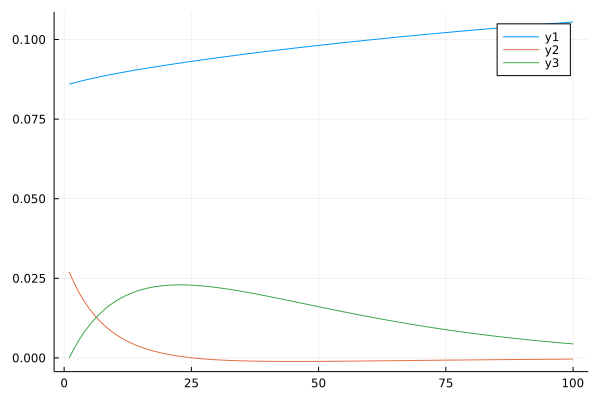

In [11]:
N = 100
evo_indiv = zeros(N)
evo_parent = zeros(N)
evo_siblings = zeros(N)
i = 1
parameters["s_u"] = 0.4
parameters["s_jx"] = 0.7
parameters["s_jy"] = 0.9
for h_x in range(0,1,N)
    parameters["h_x"] = h_x
    parameters["h_x_bar"] = h_x
    evo_indiv[i], evo_parent[i], evo_siblings[i] = Strength_comput(parameters)
    i += 1
end

plot(evo_indiv)
plot!(evo_parent)
plot!(evo_siblings)